In [1]:
import numpy as np
import torch
from torch import nn 
from torch.utils.data import DataLoader,Dataset
from torchvision import models
import os
from torchvision import models, transforms, datasets
from collections import defaultdict
from shutil import copy

from torch.optim import lr_scheduler, Adam
from torch.autograd import Variable
FOOD_PATH = "./food-101/"
IMG_PATH = FOOD_PATH+"images/"
META_PATH = FOOD_PATH+"meta/"
TRAIN_PATH = FOOD_PATH+"train/"
TEST_PATH = FOOD_PATH+"valid/"
MODEL_PATH = 'model_data/'
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
class FOOD101():
    def __init__(self):
        self.train_ds, self.test_ds, self.train_cls, self.test_cls = [None]*4
        self.mean = (0.485, 0.456, 0.406)
        self.dis = (0.229, 0.224, 0.225)
    def get_data_extract(self):
        if "food-101" in os.listdir():
            print("Dataset already exists")
        else:
            print("Downloading the data...")
            !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
            print("Dataset downloaded!")
            print("Extracting data..")
            !tar xzvf food-101.tar.gz
            print("Extraction done!")
        
    def _get_tfms(self):
        train_tfms = transforms.Compose([
            transforms.Resize((512,512)), 
            transforms.ToTensor(),
            
            transforms.Normalize((0.5,0.5,0.5), (1,1,1))])
       
        test_tfms = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),
             
            transforms.Normalize((0.5,0.5,0.5), (1,1,1))])        
        return train_tfms, test_tfms            
            
    def get_dataset(self,root_dir='./food-101/'):
        train_tfms, test_tfms = self._get_tfms() # transformations
        self.train_ds = datasets.ImageFolder(root=TRAIN_PATH, transform=train_tfms)
        self.test_ds = datasets.ImageFolder(root=TEST_PATH, transform=test_tfms)        
        self.train_classes = self.train_ds.classes
        self.test_classes = self.test_ds.classes

        assert self.train_classes==self.test_classes
        return self.train_ds, self.test_ds, self.train_classes

    
    def get_dls(self, train_ds, test_ds, bs, **kwargs):
        return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
               DataLoader(test_ds, batch_size=bs//2, shuffle=False, **kwargs))
    
food = FOOD101()

In [3]:
food.get_data_extract()

Dataset already exists


In [4]:
def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in classes_images.keys():
        print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!")

In [5]:
#print("Creating train data...")
#prepare_data(META_PATH+'train.txt', IMG_PATH, TRAIN_PATH)

In [6]:
#print("Creating test data...")
#prepare_data(META_PATH+'test.txt', IMG_PATH, TEST_PATH)

In [7]:
train, test, classes =  food.get_dataset()
train, test = food.get_dls(train, test, bs=4, num_workers=0)

In [8]:
classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [9]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([1, 1, 1])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([4, 3, 512, 512]) torch.Size([4])
macaroni_and_cheese
french_toast
hot_dog
pancakes


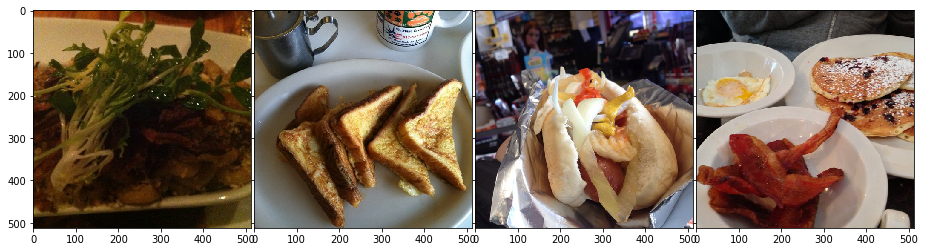

In [10]:
img, label = next(iter(train))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])
    print(classes[label[i].numpy()])

In [11]:
model = models.resnet50(pretrained = True)


In [12]:
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
for param in model.parameters():
    param.requires_grad = False

In [14]:
len(classes)

101

In [15]:
torch.cuda.is_available()

True

In [16]:
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 101)

In [36]:
model = model.cuda()

In [20]:
for image, labels in test:
    res = model(image)
    _, preds = torch.max(res.data, 1)
    print(preds.numpy())
    print(labels.numpy())

[75 48]
[0 0]
[75 17]
[0 0]
[75 48]
[0 0]
[75 38]
[0 0]
[17 48]
[0 0]
[48 75]
[0 0]
[17 75]
[0 0]
[75 17]
[0 0]
[48 85]
[0 0]
[17 75]
[0 0]
[85 75]
[0 0]
[75 48]
[0 0]
[48 75]
[0 0]
[75 85]
[0 0]
[48 75]
[0 0]
[75 48]
[0 0]


KeyboardInterrupt: 

In [58]:
model = model.cuda()

In [40]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.fc.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [48]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    best_acc = 0.0
    for epoch in range(num_epochs):
        scheduler.step()
        model.train(True)
        running_loss = 0.0
        running_corrects = 0
        in_epoch = 0
        for inputs, labels in dataloders:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            
            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == labels.data)

            train_epoch_loss = running_loss / len(train)
            train_epoch_acc = running_corrects / len(train)
            in_epoch +=1
            if in_epoch > 5000:
                break
    print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
          .format(
            epoch, num_epochs - 1,
            train_epoch_loss, train_epoch_acc))


    return model

In [49]:
len(test)

12625

In [50]:
%%time
model = train_model(train, model, criterion, optimizer, exp_lr_scheduler, num_epochs=2)

Epoch [1/1] train loss: 0.8523 acc: 0.0000 
CPU times: user 2h 45s, sys: 1h 4min 53s, total: 3h 5min 38s
Wall time: 1h 15min


In [ ]:
corr = 0
alls = 0
for image, label in train:
    result = model(image.cuda())
    _,preds = torch.max(result.data,1)
    for i, pred in enumerate(preds.cpu()):
        if label.data[i] == pred:
            corr+=1
        alls+=1

4